# Homework 7 of ECON281 Computational

This file uses sequence method to solve RBC model with and without captial.

Date: 05/20/2024

Author: Yi Zhou

Reference: Johannes' Github page, ECON210C

In [42]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## RBC model without Capital



Let's consider a standard RBC model with the following equilibrium conditions

$$
\textbf{H}_t(\textbf{Y}, \hat{a}) \equiv 
\begin{pmatrix}
\hat{a}_t + \hat{n}_{t} - \hat{y}_t \\
 \hat{a}_t - (\hat{w}_t - \hat{p}_t )\\
\varphi \hat{n}_t + \gamma \hat{c}_t - (\hat{w}_t - \hat{p}_t )\\
\hat{c}_t  - \hat{y}_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$
where $\textbf{Y} = \{\hat{c}, \hat{\iota}, \hat{k}, \hat{n}, \hat{y}, \hat{r}^k, \hat{w}-\hat{p}\}$ denotes the set of endogenous variables, and $\hat{a}$ is the only exogenous variable. 

#### The RBC without Capital DAG
The 4 equations of the RBC model without capital can be organized as three blocks which form a DAG in one unknown $\mathbf{U} = \mathbf{\hat{n}}$ and one target, the goods market clearing. 

1. Firm block:
    - $\hat{y}_t=\hat{a}_t + \hat{n}_{t} $
    - $\hat{w}_t - \hat{p}_t = \hat{a}_t $
2. Household block:
   - $\hat{w}_t - \hat{p}_t =\varphi \hat{n}_t + \gamma \hat{c}_t $
3. Market clearing block:
   - $0=\hat{c}_t -\hat{y}_t$

The image below shows a visualization of the DAG.

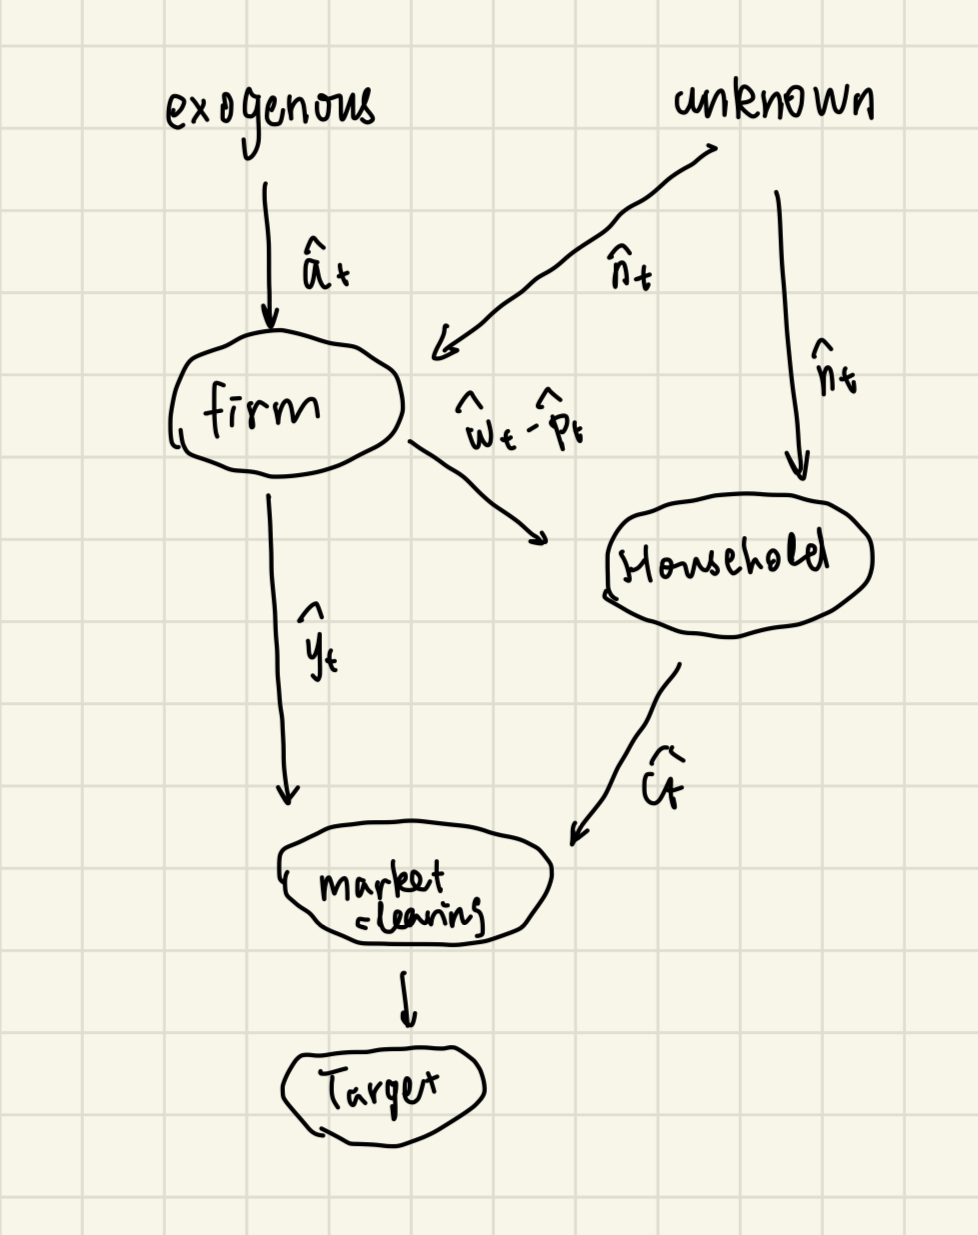

In [43]:
from IPython.display import Image

Image(filename='dag/RBC_NonCapital_DAG.jpeg') 

In [44]:
# parameterization
gamma = 1
alpha = 0.33
beta = 0.95
delta = 0.025
phi = 1
sc = 0.8
T = 100

Market clearing block and $\partial \mathbf{H}/ \partial \mathbf{Y}$

In [45]:
# define sparse identity, above-diagonal sparse matrix, below-diagonal sparse matrix, and zero matrix
I = sp.sparse.eye(T)
Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T))
Im1 = sp.sparse.diags([np.ones(T-1)], [-1], (T, T))
Z = sp.sparse.csr_matrix((T, T))

# market clearing block: goods market clearing
Phigmc = I
Phigmy = -I
Phigmwp = Z

# combine matrix blocks in a single sparse matrix with the following structure:
# [Phigmc Phigmy Phigmwp]
dHdY = sp.sparse.bmat([[Phigmc, Phigmy, Phigmwp]])

assert dHdY.shape == (T, 3*T)

Firm block and $\partial \mathbf{Y_f}/\partial \mathbf{U}$, $\partial \mathbf{Y_f}/ \partial \mathbf{Z}$

In [46]:
# firm block matrices: output
Phiya = I
Phiyn = I

# firm block matrices: labor demand
Phiwpa = I
Phiwpn = Z

# combine firm matrices in the following format:
# [Phiyn]
# [Phiwpn]
dYFdU = sp.sparse.bmat([[Phiyn],
                        [Phiwpn],
                       ])

# combine firm matrices in the following format:
# [Phiya]
# [Phiwpa]
dYFdZ = sp.sparse.bmat([[Phiya],
                       [Phiwpa]
                       ])

assert dYFdU.shape == (2*T, T)
assert dYFdZ.shape == (2*T, T)

Household block and $\partial \mathbf{Y_h}/\partial \mathbf{U}$, $\partial \mathbf{Y_h}/ \partial \mathbf{Z}$

In [47]:
# household block matrix: labor supply
Phica = 1/gamma * Phiwpa
Phicn = 1/gamma * Phiwpn - phi / gamma * I

# combine household matrices in the following format:
# [Phicn]
dYHdU = Phicn

# combine household matrices in the following format:
# [Phica]
dYHdZ = Phica

assert dYHdU.shape == (T, T)
assert dYHdZ.shape == (T, T)

Stack the household block on top of the firm block to get $\partial \mathbf{Y} / \partial \mathbf{U}$ and $\partial \mathbf{Y} / \partial \mathbf{Z}$

In [48]:
# stack dYHdU on top of dYFdU to get dYdU
dYdU = sp.sparse.bmat([[dYHdU],
                      [dYFdU]])

# stack dYHdZ on top of dYFdZ to get dYdZ
dYdZ = sp.sparse.bmat([[dYHdZ],
                      [dYFdZ]])

assert dYdU.shape == (3*T, T)
assert dYdZ.shape == (3*T, T)

Derive IRFs

In [49]:
# compute dHdU using the chain rule dHdU = dHdY @ dYdU 
dHdU = dHdY @ dYdU 

# compute dHdZ using the chain rule dHdZ = dHdY @ dYdZ 
dHdZ = dHdY @ dYdZ

assert sp.sparse.issparse(dHdZ) == True
assert sp.sparse.issparse(dHdU) == True

assert dHdU.shape == (T, T)
assert dHdZ.shape == (T, T)

# compute the Jacobian of the model
dUdZ = - sp.sparse.linalg.spsolve(dHdU, dHdZ)
dYdZ = dYdU @ dUdZ + dYdZ

dXdZ = sp.sparse.bmat([[dUdZ],
                      [dYdZ]])

assert dUdZ.shape == (T, T)
assert dYdZ.shape == (3*T, T)
assert dXdZ.shape == (4*T, T)

Plot IRF for a MIT productivity shock

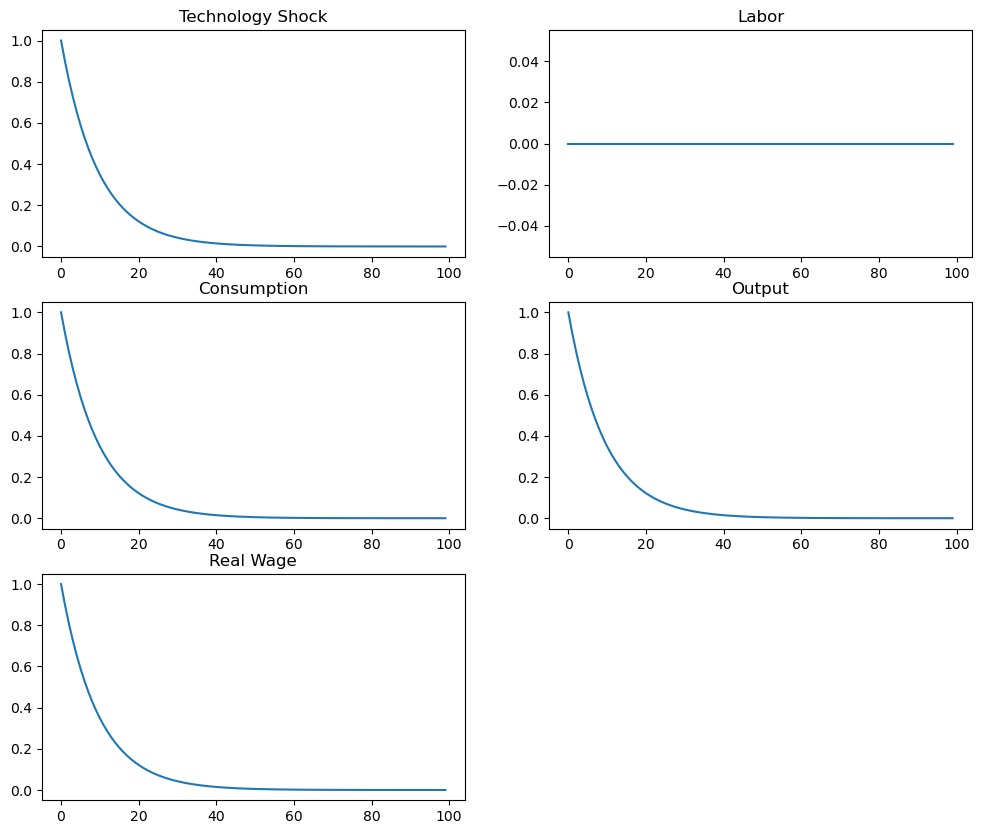

In [50]:
# plot IRFs to TFP shock with persistence rho
rho = 0.9
a = np.zeros((T, 1))
a[0] = 1
for t in range(1, T):
    a[t] = rho * a[t-1]

# compute impulse response functions
X = dXdZ @ a

# unpack X into its components 
n = X[0:T]
c = X[T:2*T]
y = X[2*T:3*T]
wp = X[3*T:4*T]

    
# plot impulse response functions
fig, ax = plt.subplots(3, 2, figsize=(12, 10))
ax[0, 0].plot(a, label='a')
ax[0, 0].set_title('Technology Shock')
ax[0, 1].plot(n, label='n')
ax[0, 1].set_title('Labor')
ax[1, 0].plot(c, label='c')
ax[1, 0].set_title('Consumption')
ax[1, 1].plot(y, label='y')
ax[1, 1].set_title('Output')
ax[2, 0].plot(wp, label='wp')
ax[2, 0].set_title('Real Wage')

fig.delaxes(ax[2, 1])

# plt.savefig('IRFs.png')



## RBC model with Capital (This is from Johannes' Github page)


Let's consider a standard RBC model with the following equilibrium conditions

$$
\textbf{H}_t(\textbf{Y}, \hat{a}) \equiv 
\begin{pmatrix}
\hat{a}_t + (1-\alpha)\hat{n}_{t} +\alpha \hat{k}_{t-1} - \hat{y}_t \\
\hat{a}_t + (1-\alpha)\hat{n}_{t} +(\alpha-1) \hat{k}_{t-1} - \hat{r}_t^k \\
 \hat{a}_t -\alpha\hat{n}_{t} +\alpha \hat{k}_{t-1} - (\hat{w}_t - \hat{p}_t )\\
\varphi \hat{n}_t + \gamma \hat{c}_t - (\hat{w}_t - \hat{p}_t )\\
s_c\hat{c}_t + (1-s_c)\hat{\iota}_t - \hat{y}_t\\
(1-\beta(1-\delta))\hat{r}_{t+1}^k -  \gamma (\hat{c}_{t+1} - \hat{c}_{t}) \\
 (1-\delta)\hat{k}_{t-1} + \delta\hat{\iota}_t - \hat{k}_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$
where $\textbf{Y} = \{\hat{c}, \hat{\iota}, \hat{k}, \hat{n}, \hat{y}, \hat{r}^k, \hat{w}-\hat{p}\}$ denotes the set of endogenous variables, and $\hat{a}$ is the only exogenous variable. 

#### The RBC DAG
The 7 equations of the RBC model can be organized as three blocks which form a DAG in two unknowns $\mathbf{U} = \{\mathbf{\hat{k}}, \mathbf{\hat{n}}\}$ and two targets, the Euler equation and goods market clearing. 

1. Firm block:
    - $\hat{y}_t=\hat{a}_t + (1-\alpha)\hat{n}_{t} +\alpha \hat{k}_{t-1} $
    - $\hat{r}_t^k=\hat{a}_t + (1-\alpha)\hat{n}_{t} +(\alpha-1) \hat{k}_{t-1} $
    - $\hat{w}_t - \hat{p}_t = \hat{a}_t -\alpha\hat{n}_{t} +\alpha \hat{k}_{t-1} $
2. Household block:
   - $\hat{w}_t - \hat{p}_t =\varphi \hat{n}_t + \gamma \hat{c}_t $
   - $\hat{k}_t = (1-\delta)\hat{k}_{t-1} + \delta\hat{\iota}_t$
3. Market clearing block:
   - $0=s_c\hat{c}_t + (1-s_c)\hat{\iota}_t -\hat{y}_t$
   - $0= (1-\beta(1-\delta))\hat{r}_{t+1}^k -  \gamma (\hat{c}_{t+1} - \hat{c}_{t})$

The DAG captures the following logic: given $\mathbf{U} = \{\mathbf{\hat{k}}, \mathbf{\hat{n}}\}$ we can solve for for $\mathbf{\hat{y}}$, $\mathbf{\hat{w}-\hat{p}}$ and $\mathbf{\hat{r}^k}$ in the firm block. Then given $\mathbf{U}$ and $\mathbf{\hat{w}-\hat{p}}$, we solve for $\mathbf{\hat{c}}$ and $\mathbf{\hat{\iota}}$ in the household block. Finally, we verify that our sequences are consistent with market clearing in the market clearing block.

The image below shows a visualization of the DAG.

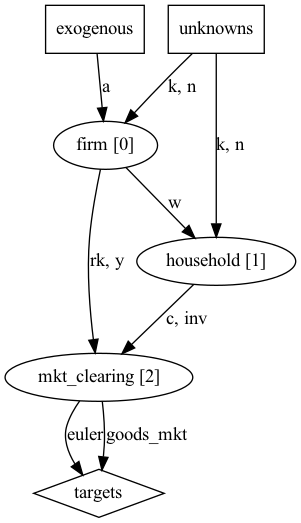

In [51]:
from IPython.display import Image

Image(filename='dag/RBC_Capital_DAG.png') 

We write the reduced system as
$$
\textbf{H}_t(\textbf{U}, \hat{a}) = 0
$$

We next set up the matrices as we did in class. First define the parameters.

In [52]:
gamma = 1
alpha = 0.33
beta = 0.95
delta = 0.025
phi = 1
sc = 0.8
T = 100

Next we set up the matrices in the market clearing block, which we use to construct $\partial \mathbf{H}/ \partial \mathbf{Y}$.

In [53]:
# define sparse identity, above-diagonal sparse matrix, below-diagonal sparse matrix, and zero matrix
I = sp.sparse.eye(T)
Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T))
Im1 = sp.sparse.diags([np.ones(T-1)], [-1], (T, T))
Z = sp.sparse.csr_matrix((T, T))

# market clearing block: goods market clearing
Phigmc = sc * I
Phigmi = (1 - sc) * I
Phigmy = -I
Phigmrk = Z
Phigmwp = Z

# market clearing block: Euler equation
Phieulc = gamma * I - gamma * Ip1
Phieuli = Z
Phieuly = Z
Phieulrk = (1 - beta * (1 - delta)) * I
Phieulwp = Z

# combine matrix blocks in a single sparse matrix with the following structure:
# [Phigmc Phigmi Phigmy Phigmrk Phigmwp]
# [Phieulc Phieuli Phieuly Phieulrk Phieulwp]
dHdY = sp.sparse.bmat([[Phigmc, Phigmi, Phigmy, Phigmrk, Phigmwp],
                       [Phieulc, Phieuli, Phieuly, Phieulrk, Phieulwp]])

assert dHdY.shape == (2*T, 5*T)

Next we construct $\partial \mathbf{Y} / \partial \mathbf{U}$ and $\partial \mathbf{Y} / \partial \mathbf{Z}$ using the blocks. Start with the firm block.

In [54]:
# firm block matrices: output
Phiya = I
Phiyk = alpha * Im1
Phiyn = (1 - alpha) * I

# firm block matrices: labor demand
Phiwpa = I
Phiwpk = alpha * Im1
Phiwpn = - alpha * I

# firm block matrices: capital demand. Note return is computed for the next period
Phirka = Ip1
Phirkk = (alpha - 1) * I
Phirkn = (1 - alpha) * Ip1

# combine firm matrices in the following format:
# [Phiyk Phiyn]
# [Phirkk Phirkn]
# [Phiwpk Phiwpn]
dYFdU = sp.sparse.bmat([[Phiyk, Phiyn],
                        [Phirkk, Phirkn],
                        [Phiwpk, Phiwpn],
                       ])

# combine firm matrices in the following format:
# [Phiya]
# [Phiwpa]
# [Phirka]
dYFdZ = sp.sparse.bmat([[Phiya],
                       [Phirka],
                       [Phiwpa]])

assert dYFdU.shape == (3*T, 2*T)
assert dYFdZ.shape == (3*T, T)

Then move on to the household block.

In [55]:
# household block matrix: labor supply
Phica = 1/gamma * Phiwpa
Phick = 1/gamma * Phiwpk
Phicn = 1/gamma * Phiwpn - phi / gamma * I

# household block matrix: capital accumulation equation
Phiia = Z
Phiik = (delta - 1) / delta * Im1 + 1 / delta * I
Phiin = Z

# combine household matrices in the following format:
# [Phick Phicn]
# [Phiik Phiin]
dYHdU = sp.sparse.bmat([[Phick, Phicn],
                       [Phiik, Phiin]])

# combine household matrices in the following format:
# [Phick Phicn]
# [Phiik Phiin]
dYHdZ = sp.sparse.bmat([[Phica],
                       [Phiia]])

assert dYHdU.shape == (2*T, 2*T)
assert dYHdZ.shape == (2*T, T)

Now stack the household block on top of the firm block to get $\partial \mathbf{Y} / \partial \mathbf{U}$ and $\partial \mathbf{Y} / \partial \mathbf{Z}$.

In [56]:
# stack dYHdU on top of dYFdU to get dYdU
dYdU = sp.sparse.bmat([[dYHdU],
                      [dYFdU]])

# stack dYHdZ on top of dYFdZ to get dYdZ
dYdZ = sp.sparse.bmat([[dYHdZ],
                      [dYFdZ]])

assert dYdU.shape == (5*T, 2*T)
assert dYdZ.shape == (5*T, T)

We have everything now to compute the solution.

In [57]:
# compute dHdU using the chain rule dHdU = dHdY @ dYdU (@ is the python matrix multiplication operator)
dHdU = dHdY @ dYdU 

# compute dHdZ using the chain rule dHdZ = dHdY @ dYdZ (@ is the python matrix multiplication operator)
dHdZ = dHdY @ dYdZ

assert sp.sparse.issparse(dHdZ) == True
assert sp.sparse.issparse(dHdU) == True

assert dHdU.shape == (2*T, 2*T)
assert dHdZ.shape == (2*T, T)

# compute the Jacobian of the model
dUdZ = - sp.sparse.linalg.spsolve(dHdU, dHdZ)
dYdZ = dYdU @ dUdZ + dYdZ

dXdZ = sp.sparse.bmat([[dUdZ],
                      [dYdZ]])

assert dUdZ.shape == (2*T, T)
assert dYdZ.shape == (5*T, T)
assert dXdZ.shape == (7*T, T)

Plot IRF for an AR(1) TFP shock with persistence rho

Text(0.5, 1.0, 'Real Wage')

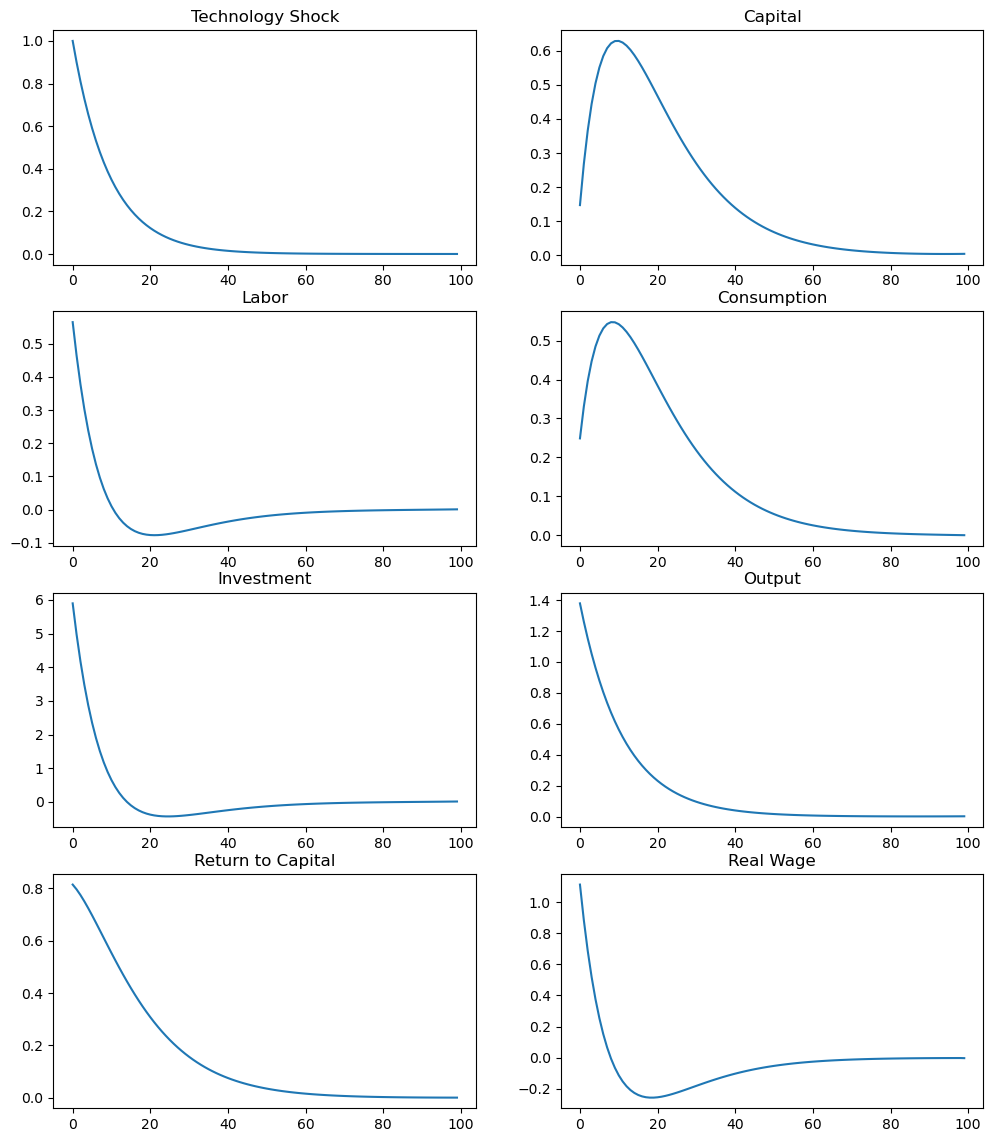

In [58]:
# plot IRFs to TFP shock with persistence rho
rho = 0.9
a = np.zeros((T, 1))
a[0] = 1
for t in range(1, T):
    a[t] = rho * a[t-1]

# compute impulse response functions
X = dXdZ @ a

# unpack X into its components k,n,c,inv,y,wp,rk
k = X[0:T]
n = X[T:2*T]
c = X[2*T:3*T]
inv = X[3*T:4*T]
y = X[4*T:5*T]
wp = X[5*T:6*T]
rk = X[6*T:7*T]
    
# plot impulse response functions
fig, ax = plt.subplots(4, 2, figsize=(12, 14))
ax[0, 0].plot(a, label='a')
ax[0, 0].set_title('Technology Shock')
ax[0, 1].plot(k, label='k')
ax[0, 1].set_title('Capital')
ax[1, 0].plot(n, label='n')
ax[1, 0].set_title('Labor')
ax[1, 1].plot(c, label='c')
ax[1, 1].set_title('Consumption')
ax[2, 0].plot(inv, label='inv')
ax[2, 0].set_title('Investment')
ax[2, 1].plot(y, label='y')
ax[2, 1].set_title('Output')
ax[3, 0].plot(rk, label='rk')
ax[3, 0].set_title('Return to Capital')
ax[3, 1].plot(wp, label='wp')
ax[3, 1].set_title('Real Wage')
# plt.savefig('IRFs.png')

